# Домашнее задание 5. Линейные модели

In [1]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Зачитываем результат 4 домашки

In [2]:
data = np.load("out_4.dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [3]:
TRAINING_SET_URL = "twitter_train.csv"
EXAMPLE_SET_URL = "test_submition.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [4]:
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[np.where(ix)]

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [5]:
Y = df_users_train['cls'].values
Y = Y[np.where(ix)]
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (6749x222020) feature matrix, 6749 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

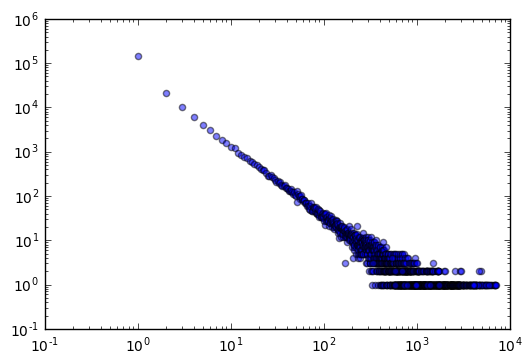

In [6]:
# по всем features смотрим у скольких пользователей 
# они встречатся : сколько features у скольких пользователей встречаются
from collections import Counter

def draw_log_hist(x):
    """Draw tokens histogram in log scales"""
    nz_num_in_columns = x.getnnz(axis=0)
    
    '''
    new_nz_num_in_columns = []
    for nz in nz_num_in_columns:
        if nz < 100 or nz > 1000:
            new_nz_num_in_columns.append(0)
        else:
            new_nz_num_in_columns.append(nz)        
    nz_num_in_columns = np.array(new_nz_num_in_columns)
    '''
    
    records = Counter(nz_num_in_columns)
    records = dict(records)
    keys = records.keys()
    values = records.values()
    
    fig = plt.figure()
    ax = plt.gca()
    ax.scatter(keys, values, c='blue', alpha=0.5)    
    ax.set_yscale('log')   
    ax.set_xscale('log')
    
    return nz_num_in_columns

features_counts = draw_log_hist(X_dataset)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

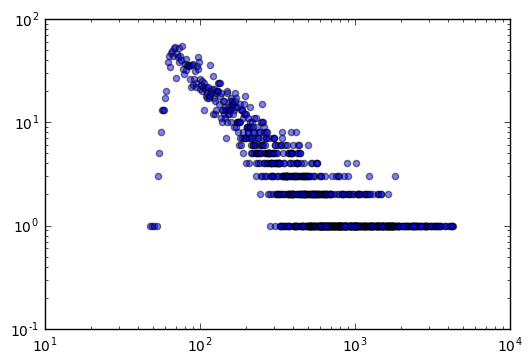

In [7]:
# tocsc() test
'''
from scipy.sparse import coo_matrix
                      
row  = array([0, 0, 1, 3, 1, 3, 0])
col  = array([0, 2, 1, 3, 1, 0, 0])
data = array([100, 1, 1, 1, 200, -50, 1])
                      
A = coo_matrix((data, (row, col)), shape=(4, 4)).tocsc()

print A.toarray()

a_counts = draw_log_hist(A)                      

print A[:, a_counts > 1].toarray()
'''

X1 = X.tocsc()[:, features_counts > 100]
draw_log_hist(X1)
X1 = X1.toarray()

Вариант задания генерируется на основании вашего ника в техносфере.

In [8]:
USER_NAME = "v.nazarov"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L1 regularization optimized by stochastic gradient descent


Реализуем выбранный алгоритм

SGD didn`t converge (reached max_iters = 10.000000)


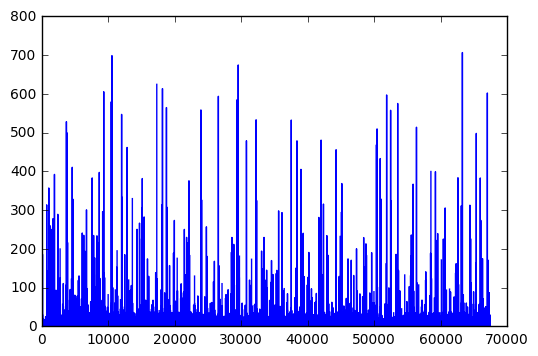

In [40]:
class LogisticRegression():
    
    def _sigmoid(self, z):
        return 1. / (1. + exp(-z))
    
    # cost for single sample with L1-regularization
    def _compute_cost(self, x, y, theta, C): 
        theta = np.array(theta)
        sigmoid_res = self._sigmoid (np.dot(theta, x))        
        J_c = -y * log(sigmoid_res) - (1-y) * log(1-sigmoid_res)
        J_c = J_c + C * np.sum(np.absolute(theta))
        return J_c

    def _cost_function_gradient(self, x, y, theta, C):
        theta = np.array(theta)
        sigmoid_res = self._sigmoid (np.dot(theta, x))
        grad = np.dot(sigmoid_res - y, x)
        grad = grad + C * np.sign (theta)
        return grad
    
    def _stochastic_gradient_descent(self, alpha, X, Y, C, tol, permute_features, max_iter):
        N = len(X[0])
        M = len(Y)
        
        cost_function_values = []
        
        # convert X and y into single matrix
        Y_T = np.reshape(np.array(Y), (M, 1))
        XY = np.append(X, Y_T, axis=1)
        
        # Reverse operation
        #Y = XX[:, N]
        #X = XX[:, :-1]
                
        #theta_0 = np.random.uniform(-0.1, 0.1, N)
        theta_0 = np.zeros(N)    
        theta = None
        new_theta = theta_0
        
        n_iter = 0
        converged = False
        while n_iter < max_iter:
            n_iter += 1        
            # random shuffle
            if permute_features:                
                XY = XY[np.random.permutation(XY.shape[0]), :]                                
            # SGD
            for example in XY:
                y = example[N]
                x = example[:-1]
                theta = new_theta
                cost_function_values.append(self._compute_cost(x, y, theta, C))            
                new_theta = theta - alpha * self._cost_function_gradient(x, y, theta, C)
                
            if np.linalg.norm(theta - new_theta) < tol:
                converged = True
                break
            if converged == True:
                break
        return new_theta, cost_function_values, n_iter

    def fit(self, X_train, y_train, alpha=0.01, C=0, tol=0.005, 
            print_cost_plot=False, permute_features=False, max_iters=3000):
        
        theta, cost_func, iters = self._stochastic_gradient_descent(alpha, X_train, y_train, C, tol,
                                                                             permute_features, max_iters)
        if iters >= max_iters:
            print "SGD didn`t converge (reached max_iters = %f)" % (max_iters)
        else:
            print "SGD converged." 
        
        if print_cost_plot:
            plt.plot(cost_func)
            
        return theta
    
    def predict(self, theta, X, thr=0.5):
        '''Predict whether the label
        is 0 or 1 using learned logistic
        regression parameters '''
        m, n = X.shape
        label = []
        probability = map(self._sigmoid, np.dot(X, theta.T))
    
        for i in range(0, len(probability)):
            if probability[i] > thr:
                label.append(1)
            else:
                label.append(0)
        
        return label, probability

'''    
from sklearn import datasets
from sklearn.cross_validation import train_test_split
iris = datasets.load_iris()
data = iris['data']
iris['setosa_target'] = [int(i==0) for i in iris['target']]
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris["setosa_target"], test_size=0.33, random_state=42)
theta = LogisticRegression().fit(X_train, y_train, alpha=0.01, C=0.01, tol=0.0005, print_cost_plot=True)
'''
theta = LogisticRegression().fit(X1, Y, alpha=0.01, C=0.001, tol=0.0001, permute_features=False, max_iters=10, print_cost_plot=True)

In [24]:
def accuracy(true_value, predicted_value):
    true_predicted = sum([1. for i in range(0, len(true_value)) if true_value[i] == predicted_value[i]])
    accuracy = true_predicted / len(true_value) * 100.0
    return accuracy

#train_predicted_label, train_predicted_prob = LogisticRegression().predict(theta, X_train)
#print 'Train Accuracy: %f' % (accuracy(y_train, train_predicted_label))
train_predicted_label, train_predicted_prob = LogisticRegression().predict(theta, X1)
print 'Train Accuracy: %f' % (accuracy(Y, train_predicted_label))

Train Accuracy: 75.892725


Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [25]:
def auroc(y_true, y_prob):
    fpr, tpr, thresholds = sm.roc_curve(y_true, y_prob, pos_label=1)
    return sm.auc(fpr, tpr)

#y = np.array(y_train)
#scores = np.array(train_predicted_label)

y = np.array(Y)
scores = np.array(train_predicted_label)

auroc(y, scores)

0.59285179632104978

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [16]:
from sklearn.cross_validation import train_test_split

C = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000]

def select_reg_parameter(C, X, Y):
    max_aur   = 0
    max_C     = 0
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)
    for c in C:
        theta = LogisticRegression().fit(X_train, y_train, alpha=0.001, C=c,
                                         tol=0.00005, permute_features=True, max_iters=10)
        train_predicted_label, train_predicted_prob = LogisticRegression().predict(theta, X_test)
        aur = auroc(y_test, train_predicted_label)
        print aur
        if aur > max_aur:
            max_aur = aur
            max_C = c    
    return C.index(max_C)

#index = select_reg_parameter(C, X1, Y)
index = 0.0

Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

SGD converged.
Area under the ROC curve : 0.505382


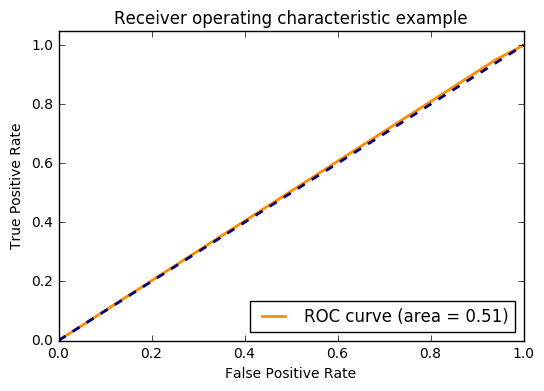

In [73]:
def classify(X, Y, test_size, C):    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    theta = LogisticRegression().fit(X_train, y_train, alpha=0.001, C=C, tol=0.00005,
                                     permute_features=True, max_iters=10)
    train_predicted_label, train_predicted_prob = LogisticRegression().predict(theta, X_test)
    fpr, tpr, thresholds = sm.roc_curve(y_test, train_predicted_label, pos_label=1)    
    roc_auc = sm.auc(fpr, tpr)
    return tpr, fpr, roc_auc

tpr, fpr, roc_auc = classify(X1, Y, 0.3, 0.0001)

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()    
    return

plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.

In [47]:
X_dataset = data["data"].reshape(1,)[0]

df_users_submition = pd.read_csv("test_submition.csv", sep=",", header=0)
df_users_submition['cls'] = None
users_submition = df_users_submition['uid'].values

ix = np.in1d(users, users_submition).reshape(users.shape)
X_subm = X_dataset[np.where(ix)]
X_subm = X_subm.tocsc()[:, features_counts > 100]
X_subm = X_subm.toarray()

cut_train = []
for i, user in enumerate(users):
    if ix[i] == True:
        cut_train.append(user)
        
print len(cut_train)        

4404


SGD didn`t converge (reached max_iters = 10.000000)
Train Accuracy: 77.878204


0.61524101443097123

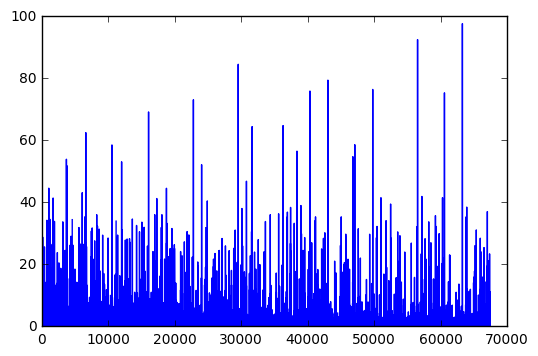

In [43]:
theta = LogisticRegression().fit(X1, Y, alpha=0.001, C=0.00, tol=0.001, 
                                 max_iters=10, print_cost_plot=True)

train_predicted_label, train_predicted_prob = LogisticRegression().predict(theta, X1)
print 'Train Accuracy: %f' % (accuracy(Y, train_predicted_label))

y = np.array(Y)
scores = np.array(train_predicted_label)

auroc(y, scores)

In [44]:
train_predicted_label, train_predicted_prob = LogisticRegression().predict(theta, X_subm)

In [50]:
#print len (users_submition)
#print len (train_predicted_prob)

predicted_list = []
for i, uid in enumerate(users_submition):
        if uid in cut_train:
            j = cut_train.index(uid);  
            predicted_list.append(train_predicted_prob[j])
        else:
            #predicted_list.append(pr.uniform(0, 1))
            predicted_list.append(1)

predicted_list = np.array(predicted_list)
#print len (predicted_list)  
#print predicted_list[:20]
#print train_predicted_prob[:20]

In [51]:
b = pd.DataFrame()
b["uid"] = users_submition
b["cls"] = predicted_list
b.to_csv("My_Submission.csv",index = False)